# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First five samples of X: \n{X[:5]}")
print(f"First five samples of y: \n{y[:5]}")

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

First five samples of X: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First five samples of y: 
[1 1 1 1 0]
Shape of X: (1000, 2)
Shape of y: (1000,)


In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                        "label" : y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [6]:
circles.label.value_counts()

,count
label,
1,500
0,500


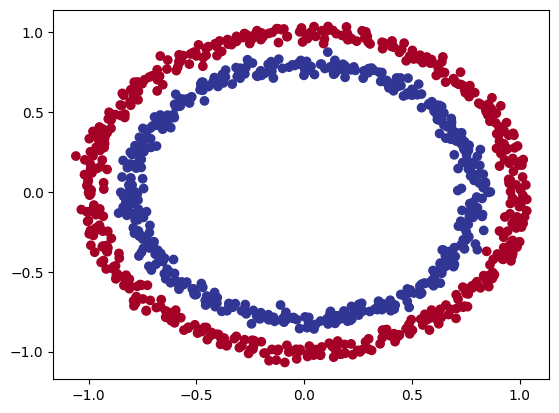

In [7]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1. Check input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [10]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shape of X_sample: {X_sample.shape} and shape of y_sample: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shape of X_sample: (2,) and shape of y_sample: ()


### 1.2 Turn data into tensors and create train and test splits

In [11]:
import torch
torch.__version__

'2.5.1+cu121'

In [12]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define loss function and optimizer
4. Create a training and test loop


In [16]:
# Import pytorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [17]:
# 1. Construct a model that subclasses nn.Module
class CircleModelv0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_2(self.layer_1(x))

# 4. Instantiate an instance of our model class and send it to the target class
model_0 = CircleModelv0().to(device)
model_0

CircleModelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
next(model_0.parameters()).device

device(type='cpu')

In [19]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0889,  0.1235],
                      [-0.6206, -0.4250],
                      [ 0.5714, -0.1584],
                      [ 0.6388, -0.5002],
                      [ 0.5386,  0.5910]])),
             ('0.bias', tensor([-0.3759, -0.2611,  0.2957,  0.4336, -0.4961])),
             ('1.weight', tensor([[0.4030, 0.3179, 0.3000, 0.1954, 0.4359]])),
             ('1.bias', tensor([-0.3673]))])

In [21]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Untrained model predictions: {torch.round(untrained_preds[:10])}")

Untrained model predictions: tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-0.],
        [-0.],
        [-0.],
        [-1.],
        [-1.]])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should we use?

Again.. this is problem specific

For example you might want MAE or MSE.

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

In [22]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [23]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

### 3. Train model

To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward
5. Optimizer step

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (eg. sigmoid for binary classification and softmax for multiclass classification problem).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [24]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.7649],
        [-0.6130],
        [-0.9128],
        [-0.7240],
        [-0.5160]])

In [25]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3176],
        [0.3514],
        [0.2864],
        [0.3265],
        [0.3738]])

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [26]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), torch.squeeze(y_pred_labels)))

tensor([True, True, True, True, True])


In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ## Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits,  # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.74974, Acc: 50.00% | Test Loss: 0.74895, Test Acc: 50.00%
Epoch: 10 | Loss: 0.71652, Acc: 50.00% | Test Loss: 0.71791, Test Acc: 50.00%
Epoch: 20 | Loss: 0.70494, Acc: 44.25% | Test Loss: 0.70637, Test Acc: 44.50%
Epoch: 30 | Loss: 0.70028, Acc: 48.38% | Test Loss: 0.70135, Test Acc: 44.50%
Epoch: 40 | Loss: 0.69805, Acc: 50.12% | Test Loss: 0.69878, Test Acc: 44.50%
Epoch: 50 | Loss: 0.69676, Acc: 49.88% | Test Loss: 0.69726, Test Acc: 44.50%
Epoch: 60 | Loss: 0.69591, Acc: 49.75% | Test Loss: 0.69626, Test Acc: 44.00%
Epoch: 70 | Loss: 0.69531, Acc: 50.12% | Test Loss: 0.69557, Test Acc: 43.50%
Epoch: 80 | Loss: 0.69485, Acc: 50.38% | Test Loss: 0.69507, Test Acc: 44.00%
Epoch: 90 | Loss: 0.69450, Acc: 50.25% | Test Loss: 0.69471, Test Acc: 44.00%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual

To do so, we're going to import a function called plot_decision_boundary()

In [29]:
import requests
from pathlib import Path

# Download helper function from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

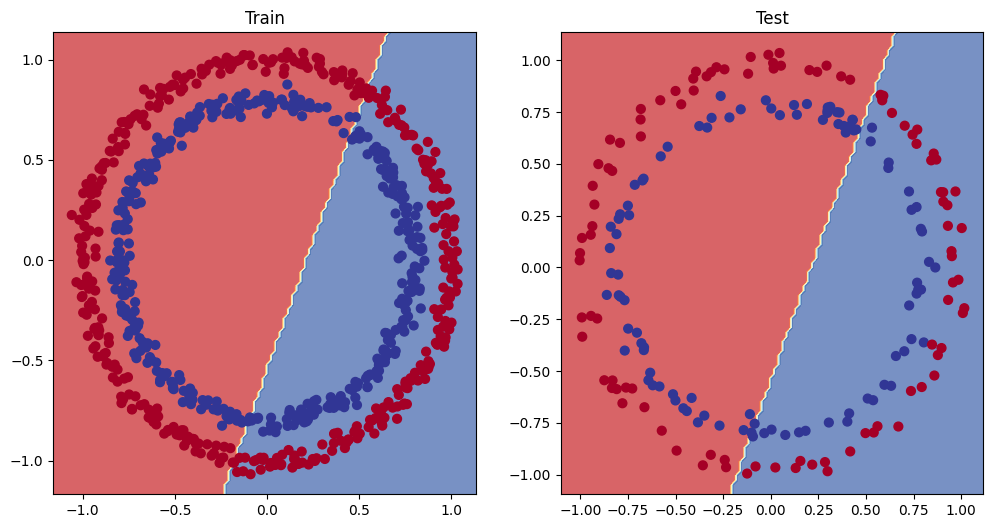

In [30]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as **hyperparameters**.

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs 100 -> 1000

In [31]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # This way of writing operations leverages speeds up where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
# Create a loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)


In [33]:
# Write training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test Loss: 0.69379, Test Acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test Loss: 0.69437, Test Acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test Loss: 0.69458, Test Acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69465, Test Acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69467, Test Acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%


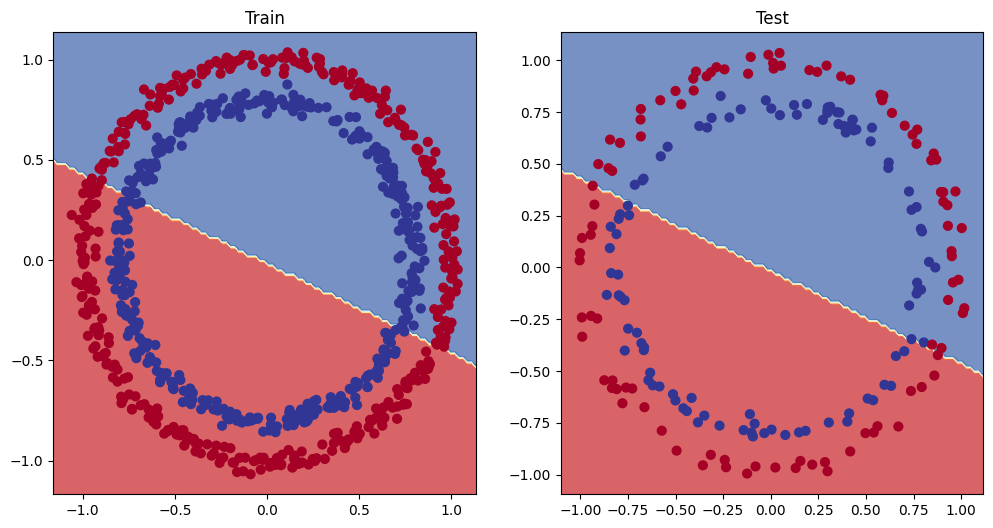

In [34]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [35]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [36]:
# Create train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the length of each
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

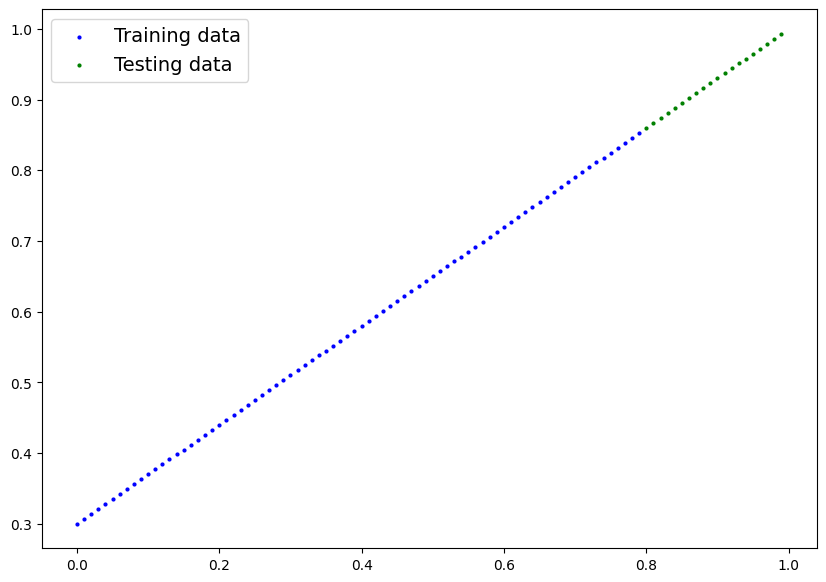

In [37]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjust `model_1` to fit a straight line

In [38]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [39]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [40]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  ### Training
  model_2.train()

  # 1. Forward pass
  y_pred = model_2(X_train_regression)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train_regression)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_2.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_pred = model_2(X_test_regression)

    # 2. Calculate loss
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test Loss: 0.00360


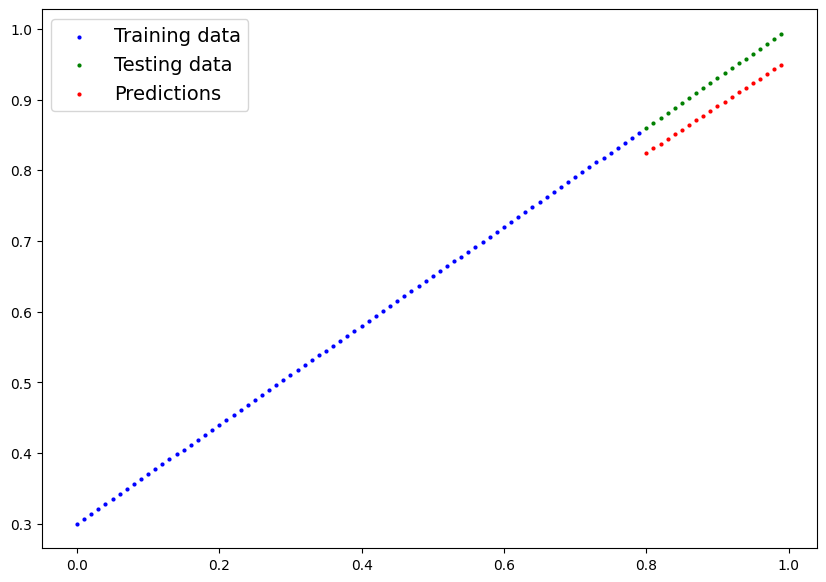

In [41]:
# Turn on evaluation mode
model_2.eval()

# Make predictions
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

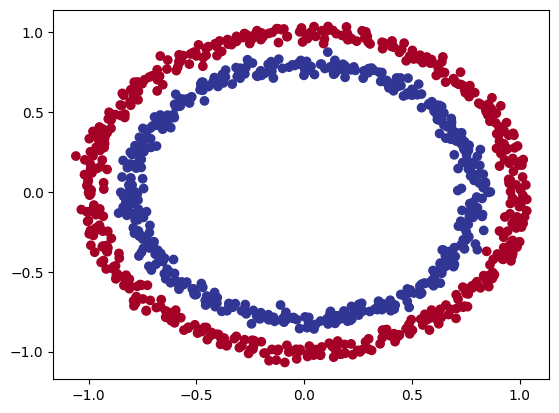

In [42]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)


In [43]:
# Convert data to tensors and then to train and test split
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test splits
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear = straight lines
* Non-linear = non-straight lines

ANNs are a large combination of linear and non-linear functions which are potentially able to find patterns in data.

In [44]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [45]:
# Setup loss and optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

### 6.3 Training a model with non-linearity

In [46]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calulate loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6929 | Acc: 50.00% | Test Loss: 0.6932 | Test Acc: 50.00%
Epoch: 100 | Loss: 0.6912 | Acc: 52.88% | Test Loss: 0.6910 | Test Acc: 52.50%
Epoch: 200 | Loss: 0.6898 | Acc: 53.37% | Test Loss: 0.6894 | Test Acc: 55.00%
Epoch: 300 | Loss: 0.6879 | Acc: 53.00% | Test Loss: 0.6872 | Test Acc: 56.00%
Epoch: 400 | Loss: 0.6852 | Acc: 52.75% | Test Loss: 0.6841 | Test Acc: 56.50%
Epoch: 500 | Loss: 0.6810 | Acc: 52.75% | Test Loss: 0.6794 | Test Acc: 56.50%
Epoch: 600 | Loss: 0.6751 | Acc: 54.50% | Test Loss: 0.6729 | Test Acc: 56.00%
Epoch: 700 | Loss: 0.6666 | Acc: 58.38% | Test Loss: 0.6632 | Test Acc: 59.00%
Epoch: 800 | Loss: 0.6516 | Acc: 64.00% | Test Loss: 0.6476 | Test Acc: 67.50%
Epoch: 900 | Loss: 0.6236 | Acc: 74.00% | Test Loss: 0.6215 | Test Acc: 79.00%


### 6.4 Evaluating a model trained with non-linear activation functions

In [47]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_pred = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_pred[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

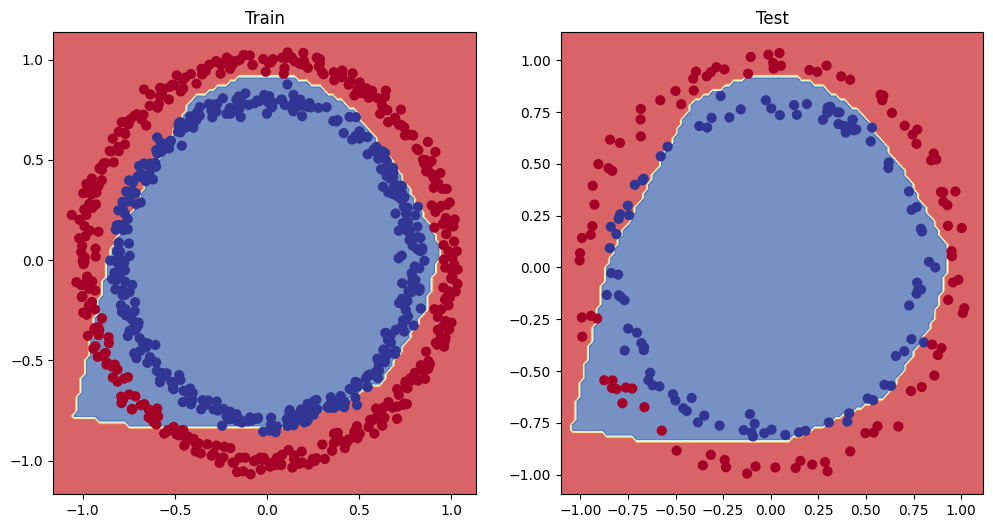

In [48]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear and non-linear functions.

In [49]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [50]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

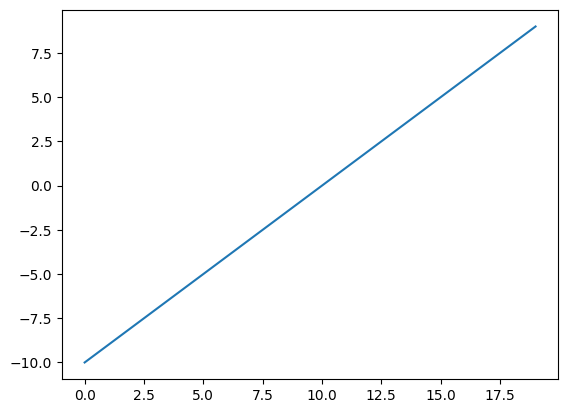

In [51]:
# Visualize the tensor
plt.plot(A)

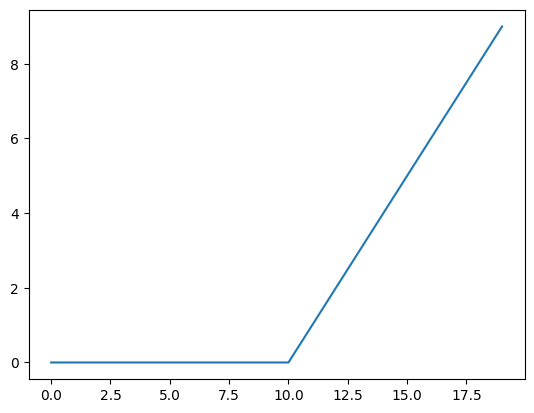

In [52]:
plt.plot(torch.relu(A))

In [53]:
def relu(x:torch.Tensor) -> torch.Tensor:
  return torch.maximum(x, torch.tensor(0))

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [54]:
# Now let's do the same for sigmoid
def sigmoid(x:torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

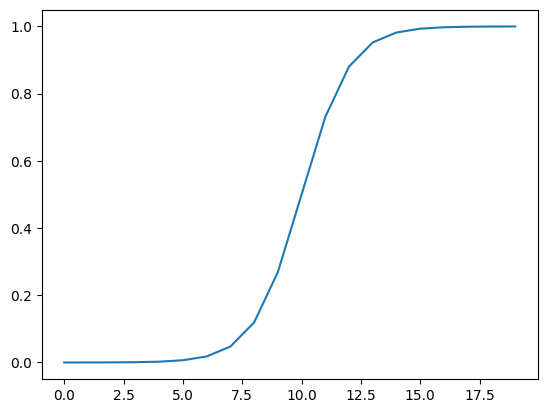

In [55]:
 plt.plot(torch.sigmoid(A))

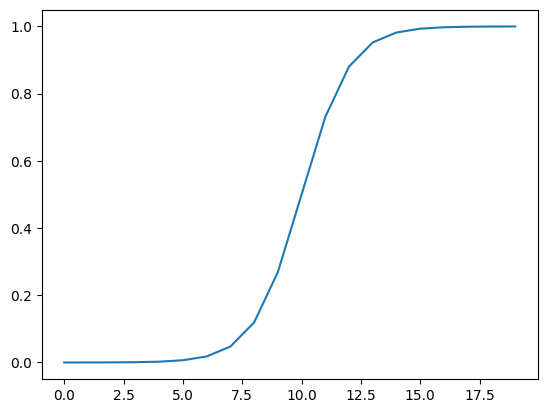

In [56]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

### 8.1 Creating a toy multi-class dataset

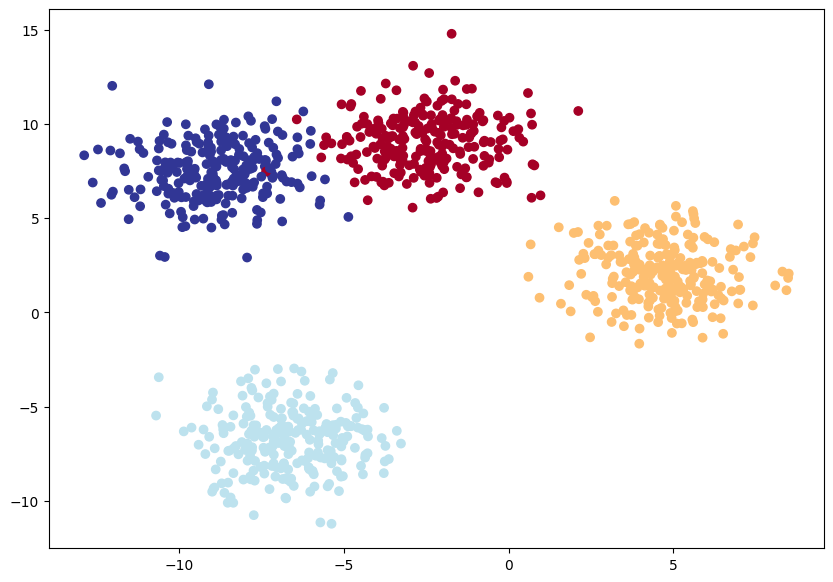

In [57]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameter for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [58]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [59]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model.
      output_features (int): Number of output features of the model.
      hidden_units (int): Number of hidden units between layers, default 8.
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
        )

  def forward(self, x:torch.Tensor) -> torch.Tensor:
      return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [60]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)


### 8.4. Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's output (logits) to prediction probabilities and then to prediction labels

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take argmax of the prediction probabilities)

In [61]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]])

In [62]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [63]:
# Convert our model's logits output to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]])


In [64]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3])

In [65]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Create a training loop and testing loop for a multi-class PyTorch model

In [66]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put the data on the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()

  # 1. Forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate loss
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    # 2 Calculate loss
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_pred)

  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss:{test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.0432, Acc: 65.50% | Test Loss:0.5786, Test Acc: 95.50%
Epoch: 10 | Loss: 0.1440, Acc: 99.12% | Test Loss:0.1304, Test Acc: 99.00%
Epoch: 20 | Loss: 0.0806, Acc: 99.12% | Test Loss:0.0722, Test Acc: 99.50%
Epoch: 30 | Loss: 0.0592, Acc: 99.12% | Test Loss:0.0513, Test Acc: 99.50%
Epoch: 40 | Loss: 0.0489, Acc: 99.00% | Test Loss:0.0410, Test Acc: 99.50%
Epoch: 50 | Loss: 0.0429, Acc: 99.00% | Test Loss:0.0349, Test Acc: 99.50%
Epoch: 60 | Loss: 0.0391, Acc: 99.00% | Test Loss:0.0308, Test Acc: 99.50%
Epoch: 70 | Loss: 0.0364, Acc: 99.00% | Test Loss:0.0280, Test Acc: 99.50%
Epoch: 80 | Loss: 0.0345, Acc: 99.00% | Test Loss:0.0259, Test Acc: 99.50%
Epoch: 90 | Loss: 0.0330, Acc: 99.12% | Test Loss:0.0242, Test Acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [67]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 logits
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])

In [68]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.4332e-03, 9.9757e-01, 1.0804e-11, 1.8271e-09],
        [3.4828e-03, 1.3697e-10, 6.8363e-04, 9.9583e-01],
        [2.8657e-12, 1.2266e-15, 9.9973e-01, 2.6959e-04],
        [3.2692e-03, 9.9673e-01, 9.5435e-08, 4.7619e-07],
        [9.9168e-01, 8.3089e-03, 1.4120e-10, 8.2969e-06],
        [4.5039e-04, 5.4287e-13, 2.5532e-04, 9.9929e-01],
        [1.6306e-11, 2.4030e-13, 9.9987e-01, 1.3003e-04],
        [9.9860e-01, 3.9485e-04, 5.9937e-08, 1.0045e-03],
        [3.0436e-14, 6.8303e-20, 9.9965e-01, 3.5218e-04],
        [9.9843e-01, 1.3657e-03, 9.0767e-09, 2.0006e-04]])

In [69]:
# Go from pred probs -> pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [70]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

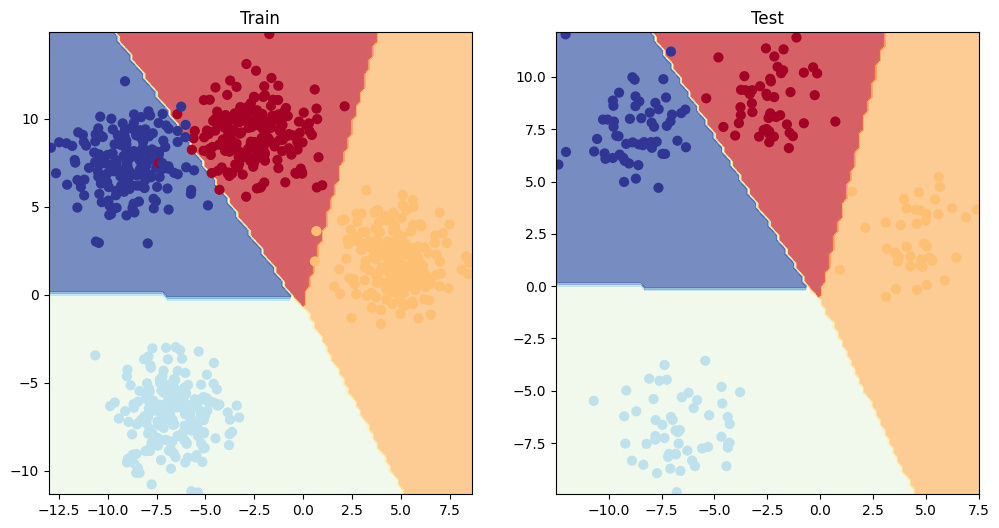

In [71]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-Score
* Confusion matrix
* Classification report

In [74]:
!pip install torchmetrics

In [79]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950)

In [78]:
torchmetric_accuracy.device

device(type='cpu')